In [1]:
import tensorflow as tf
import os
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import image
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses


train_path = 'C:/Users/ZAKAR/Documents/GitHub/AIFFEL/Exploration/Quest17_EX07/data/train/'
val_path = 'C:/Users/ZAKAR/Documents/GitHub/AIFFEL/Exploration/Quest17_EX07/data/val/'

In [2]:
def load_n_normalize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    w = tf.shape(img)[1] // 2
    ground_truth = img[:, :w, :]
    ground_truth = tf.cast(ground_truth, tf.float32)
    input_image = img[:, w:, :]
    input_image = tf.cast(input_image, tf.float32)
    norm_ground = (ground_truth/127.5) - 1
    norm_input = (input_image/127.5) - 1
    return norm_ground, norm_input

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

f = train_path + os.listdir(train_path)[1]
ground_truth, input_image = load_n_normalize(f)

In [3]:
# Augmentation 기법으로 좌우반전, 상하반전, 회전을 적용하였다.
def augmentation(input_image, ground_truth):
    # input_image와 ground_truth를 가로 방향(axis=-1)으로 결합
    stacked = tf.concat([input_image, ground_truth], axis=-1)
    # 패딩(padding)을 설정하기 위한 상수 텐서를 생성
    padding = tf.constant([[30,30],[30,30],[0,0]])
    # 50%의 확률로 아래 조건문이 실행
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, padding, "REFLECT")
    else:
        padded = tf.pad(stacked, padding, "CONSTANT", constant_values=1.)
    # 확장된 이미지를 크기가 256x256이 되도록 무작위로 자르는(random crop) 작업을 수행
    out = image.random_crop(padded, size=[256, 256, 6])
    # 이미지를 좌우로 무작위로 뒤집는 작업을 수행
    out = image.random_flip_left_right(out)
    # 이미지를 상하로 무작위로 뒤집는 작업을 수행
    out = image.random_flip_up_down(out)
    if tf.random.uniform(()) < .5:
        # 1~4 사이의 정수를 선택, 이 값은 이미지를 시계 방향으로 90도씩 회전하는데 사용
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    # 최종 변형된 이미지 out를 입력 이미지와 정답 이미지로 분할하여 반환
    # out[...,:3]는 채널 차원이 3까지인 이미지로 입력 이미지를, out[...,3:]는 채널 차원이 3 이후인 이미지로 정답 이미지를 나타낸다.
    return out[...,:3], out[...,3:]

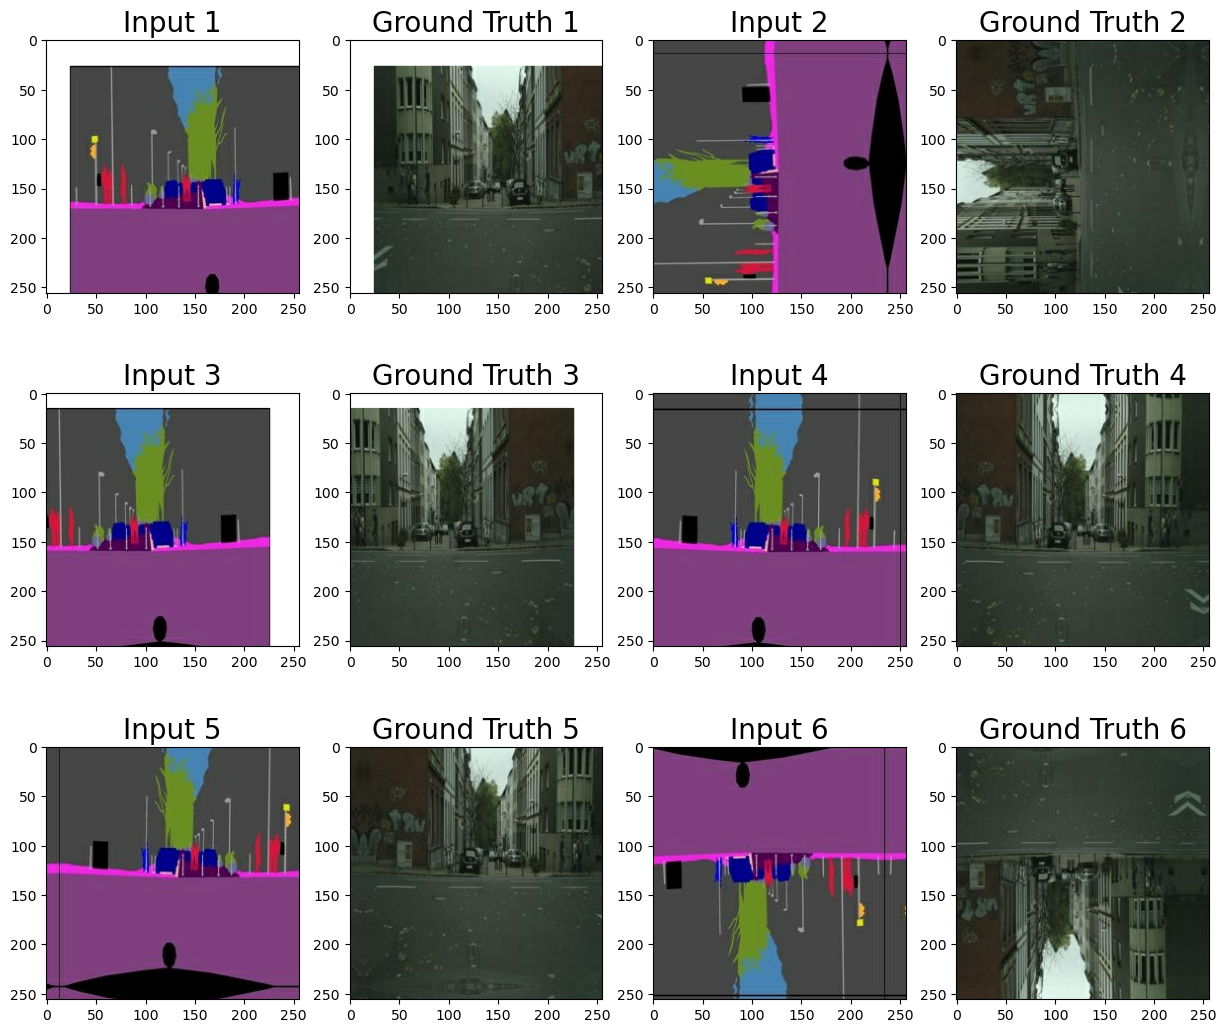

In [4]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_input, augmented_ground = augmentation(input_image, ground_truth)
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_input))
    plt.title(f'Input {img_n}', fontsize=20)
    plt.subplot(3,4,i+1)
    plt.imshow(denormalize(augmented_ground))
    plt.title(f'Ground Truth {img_n}', fontsize=20)
    img_n += 1

In [5]:
def get_train(train_path):
    input_image, ground_truth = load_n_normalize(train_path)
    input_image, ground_truth = augmentation(input_image, ground_truth)
    return input_image, ground_truth

train_images = tf.data.Dataset.list_files(train_path + '*.jpg')
train_images = train_images.map(get_train).shuffle(100).batch(4)

In [6]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)


class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [7]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]

        # skip connection
        # 인코더에서 생성된 특성 맵은 features 리스트에 저장되고, 디코더의 각 블록과 함께 사용
        # 디코더 블록을 거치면서 특성 맵의 크기가 점차 증가하면서 업샘플링되고, 해당 디코더 블록의 출력과 이전 단계의 인코더 특성 맵을 연결(concatenate)
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [8]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [9]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")

        filters = [64,128,256,512,1]
        self.blocks = [layers.Concatenate()]
        for i, f in enumerate(filters):
            self.blocks.append(DiscBlock(
                n_filters=f,
                stride=2 if i < 3 else 1,
                custom_pad=False if i < 3 else True,
                use_bn=False if i == 0 and i == 4 else True,
                act=True if i < 4 else False
            ))

    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [10]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    # 실제 이미지와 가짜 이미지 간의 평균절대오차 계산
    l1_loss = mae(real_output, fake_output)
    # 가짜 이미지 판별 결과에 대한 이진 교차 엔트로피 손실 계산
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    # 가짜 이미지에 대한 이진 크로스 엔트로피 손실과 실제 이미지에 대한 이진 크로스 엔트로피 손실을 합산하여 판별자의 손실을 반환
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [11]:
gene_opt = tf.keras.optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [12]:
# 훈련 스텝을 수행하는 함수
# 스케치(sketch)와 실제 컬러 이미지(real_colored) 데이터를 입력으로 받아 생성자(generator)와 판별자(discriminator) 모델을 사용하여 훈련을 수행
def train_step(sketch, real_colored, generator, discriminator):
    # gene_tape와 disc_tape를 생성하여 그래디언트(gradient) 계산을 위한 컨텍스트를 설정
    # 이 컨텍스트 안에서 수행되는 모든 연산의 그래디언트가 기록되고 추적
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        fake_colored = generator(sketch, training=True)
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss)
        disc_loss = get_disc_loss(fake_disc, real_disc)
    
    # 생성자의 가중치와 판별자의 가중치에 대한 gradient를 계산
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # 계산한 graidient를 적용, 업데이트
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [13]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

checkpoint_dir = 'C:/Users/ZAKAR/Documents/GitHub/AIFFEL/Exploration/Quest17_EX07/training_checkpoints/'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer =gene_opt,
                                 discriminator_optimizer=disc_opt,
                                 generator=generator,
                                 discriminator=discriminator)

In [14]:
val_len = len(os.listdir(val_path))

def generate_n_save_images(generator, epoch, it):
    plt.figure(figsize=(24, 16))
    for i in range(val_len):
        f = val_path + os.listdir(val_path)[i]
        grount_truth, input_image = load_n_normalize(f)
        pred = generator(tf.expand_dims(input_image, 0), training=False)
        pred = denormalize(pred)
        plt.subplot(1, 5, i+1)
        plt.imshow(pred[0])
        plt.axis('off')
    plt.savefig('C:/Users/ZAKAR/Documents/GitHub/AIFFEL/Exploration/Quest17_EX07/generated/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.show()

In [15]:
# 훈련 중의 손실값들을 저장할 딕셔너리 생성
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}

# 주어진 데이터셋(train_images)을 사용하여 생성자와 판별자를 훈련하는 함수
def train(train_images, epochs, save, generator, discriminator):
    for epoch in range(1, EPOCHS+1):
        for i, (input_image, ground_truth) in enumerate(train_images):
            g_loss, l1_loss, d_loss = train_step(input_image, ground_truth, generator, discriminator)
            history['gen_loss'].append(g_loss)
            history['l1_loss'].append(l1_loss)
            history['disc_loss'].append(d_loss)
            if (i+1) % 50 == 0:
                display.clear_output(wait=False)
                generate_n_save_images(generator, epoch + 1, i + 1)
                print(f'EPOCH[{epoch}] - STEP[{i+1}] \
                      \nGenerator_loss: {g_loss.numpy():.4f} \
                      \nL1_loss: {l1_loss.numpy():.4f} \
                      \nDiscriminator_loss: {d_loss.numpy():.4f}')
        if epoch % save == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        display.clear_output(wait=False)
        generate_n_save_images(generator, epoch, i)
        

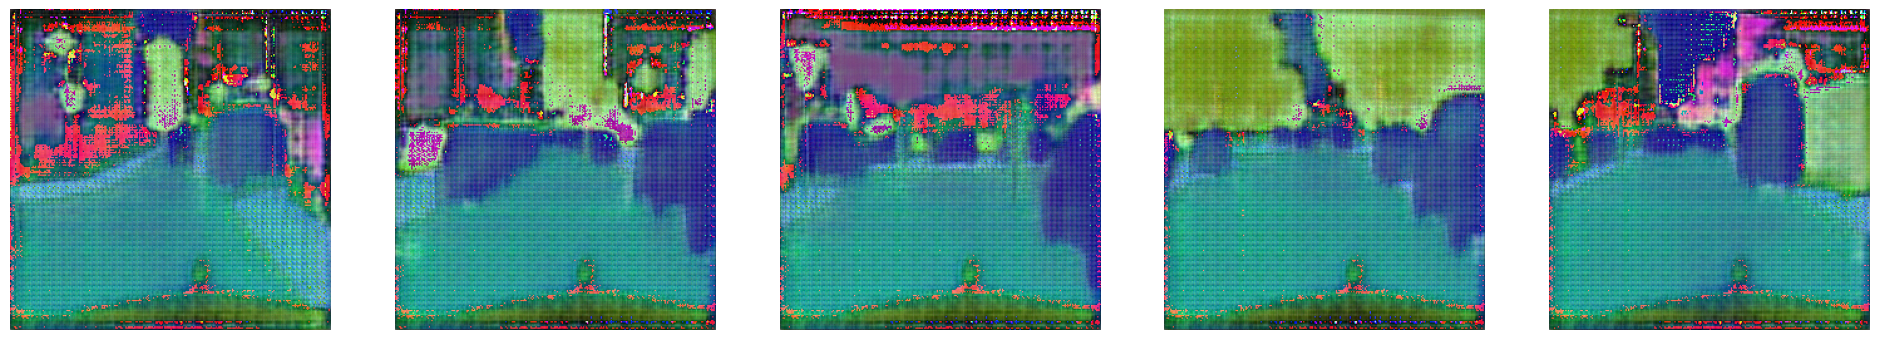

In [16]:
EPOCHS = 20
save = 5
with tf.device('/GPU:0'):
    train(train_images, EPOCHS, save, generator, discriminator)

Text(0.5, 1.0, 'grount_truth')

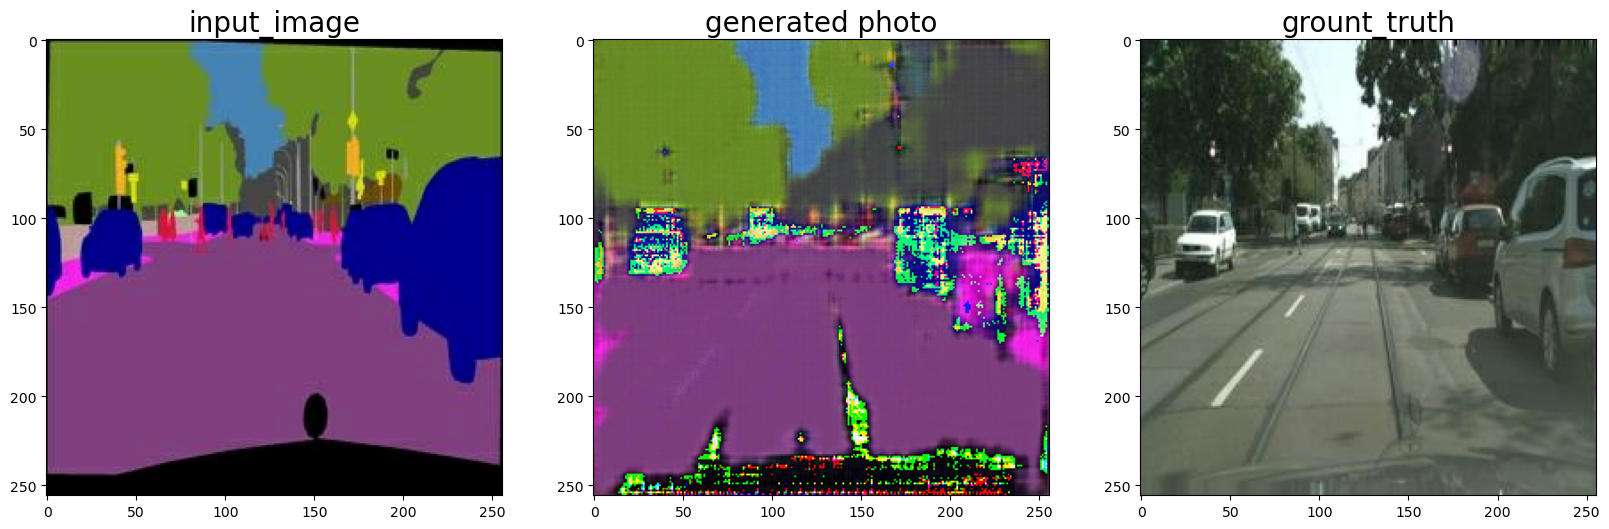

In [20]:
f = val_path + os.listdir(val_path)[3]
ground_truth, input_image = load_n_normalize(f)

pred = generator(tf.expand_dims(ground_truth, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))

plt.subplot(1,3,1); plt.imshow(denormalize(input_image)); plt.title('input_image', fontsize=20)
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('generated photo', fontsize=20)
plt.subplot(1,3,3); plt.imshow(denormalize(ground_truth)); plt.title('grount_truth', fontsize=20)



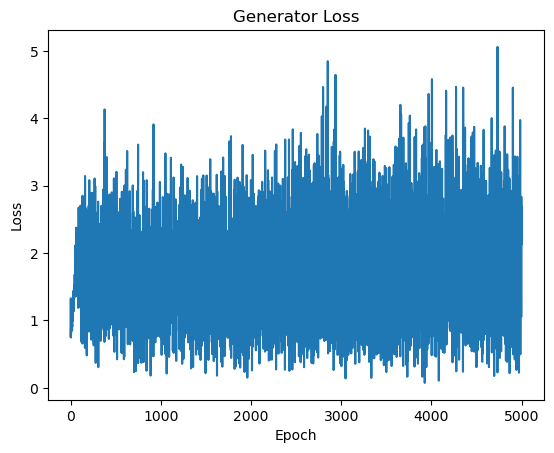

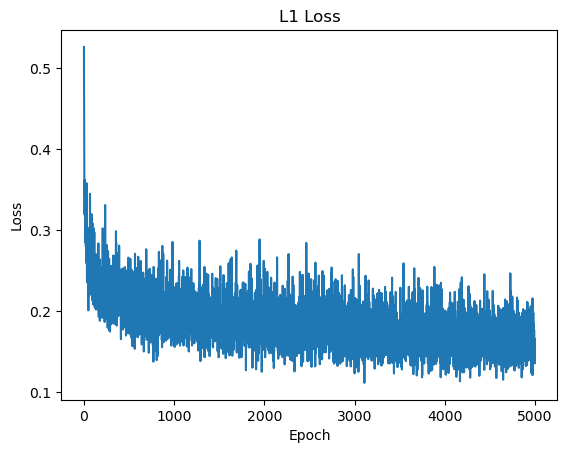

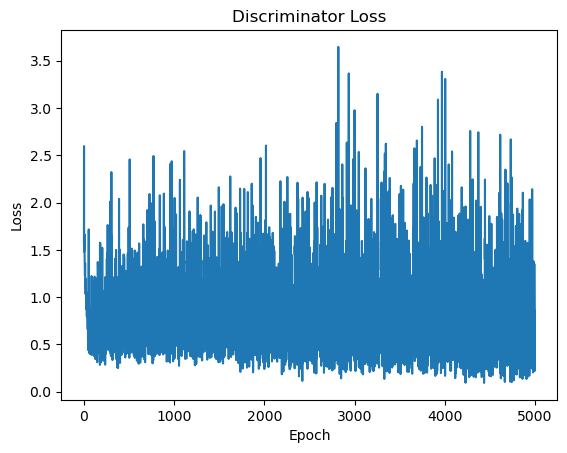

In [22]:
# 생성자 손실 그래프
gen_loss = np.array(history['gen_loss'])
plt.plot(gen_loss)
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# L1 손실 그래프
l1_loss = np.array(history['l1_loss'])
plt.plot(l1_loss)
plt.title('L1 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 판별자 손실 그래프
disc_loss = np.array(history['disc_loss'])
plt.plot(disc_loss)
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()